In [1]:
import keras
import random
import tensorflow as tf
import keras.backend as K
from keras.models import Model
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.random.seed(42) # NumPy
random.seed(42) # Python
tf.random.set_seed(42) # Tensorflow
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_pickle('final_train_data.pkl')

In [3]:
# Feature selection
X = train_data.drop(['isFraud'], axis=1)
y = train_data['isFraud']
# split the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)


In [4]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0, sampling_strategy=0.9)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [5]:
X_train_resampled.shape

(35063, 171)

In [89]:
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix2(cm, classes):
    total_samples = cm.sum()

    # Calculate count and percentage matrices
    cm_count = cm
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot count confusion matrix
    sns.heatmap(cm_count, annot=True, fmt="d", cmap='Blues', ax=ax1)

    # Add count labels
    for i in range(cm_count.shape[0]):
        for j in range(cm_count.shape[1]):
            ax1.text(j + 0.5, i + 0.5, str(cm_count[i, j]), ha='center', va='center', color='black')

    ax1.set_title('Confusion Matrix (Count)')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')

    # Plot percentage confusion matrix
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues', ax=ax2)

    # Add percentage labels
    for i in range(cm_percent.shape[0]):
        for j in range(cm_percent.shape[1]):
            ax2.text(j + 0.5, i + 0.5, "{:.1f}%".format(cm_percent[i, j]), ha='center', va='center', color='black')

    ax2.set_title('Confusion Matrix (Percentage)')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')

    # Adjust layout
    plt.tight_layout()

    # Add labels for each quadrant
    plt.text(-1.2, -0.5, 'True Negative', ha='center', va='center', color='black')
    plt.text(-1.2, 0.5, 'False Negative', ha='center', va='center', color='black')
    plt.text(0.2, -0.5, 'False Positive', ha='center', va='center', color='black')
    plt.text(0.2, 0.5, 'True Positive', ha='center', va='center', color='black')

    # Show the plot
    plt.show()


# Model 1

In [6]:
model1 = tf.keras.models.load_model("baseline_model/base_model_v1_epoch_17_recall0.77_auc0.82_checkpoint.h5")

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [7]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               88064     
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 257       
                                                                 
Total params: 219,649
Trainable params: 219,649
Non-trainable params: 0
_________________________________________________________________


In [8]:
# tensorflow model prediction
y_pred = model1.predict(X_val)
y_pred_binary = np.round(y_pred).flatten()
cm = confusion_matrix(y_val, y_pred_binary)

   1/3691 [..............................] - ETA: 10:03

2023-05-29 19:26:09.617920: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3691/3691 [==============================] - 5s 1ms/step


In [9]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

[Text(0, 0.5, 'Non Fraud'), Text(0, 1.5, 'Fraud')]

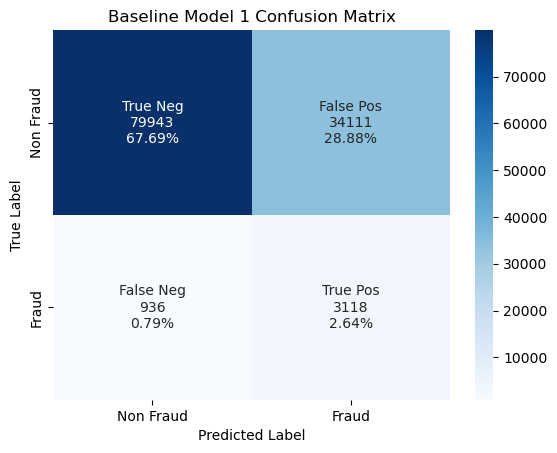

In [11]:
fig, ax = plt.subplots()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.title("Baseline Model 1 Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
ax.xaxis.set_ticklabels(['Non Fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Non Fraud', 'Fraud'])

In [12]:
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
fpr

0.29907762989461134

In [15]:
from sklearn.metrics import auc, roc_curve
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = (2 * recall * precision) / (recall + precision)
y_pred_keras = y_pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

print(f"FPR: {fpr}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")
print(f"AUC: {auc_keras}")


FPR: 0.29907762989461134
Recall: 0.7691169215589542
Precision: 0.08375191383061592
Accuracy: 0.7032631151149795
F1: 0.1510549136448417
AUC: 0.8204181106571966


In [16]:
y_val.value_counts(normalize=True)

isFraud
0    0.965675
1    0.034325
Name: proportion, dtype: float64

In [17]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

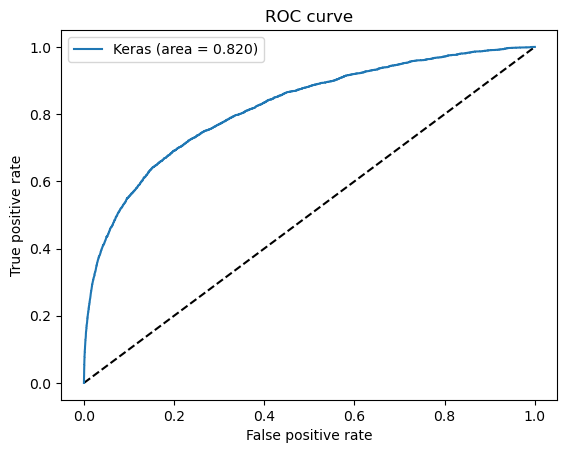

In [18]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

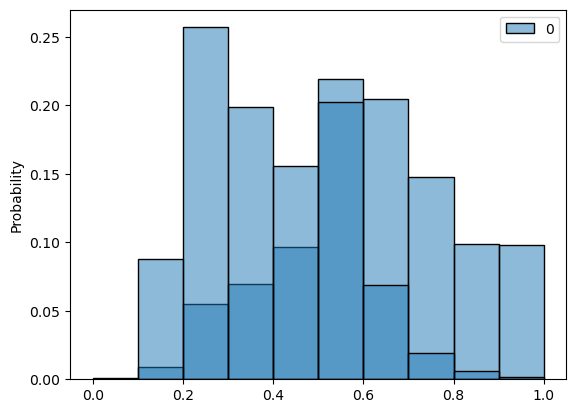

In [157]:
sns.histplot(predicted, binrange=(0, 1), stat="probability", bins=10, hue label="Fraud")
sns.histplot(non_fraud_cases, binrange=(0, 1), stat="probability", bins=10, color="red", label="Non Fraud")
plt.show()

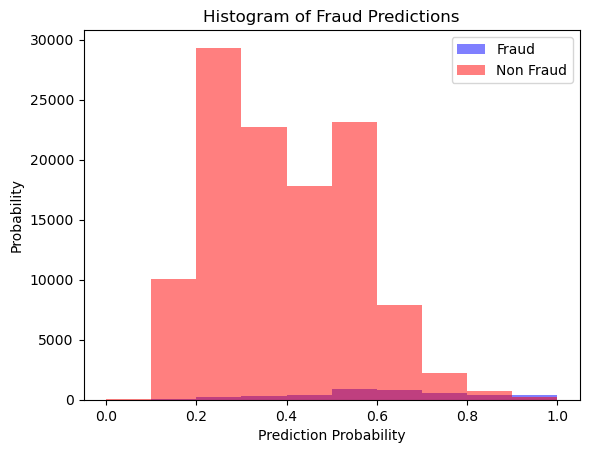

In [162]:
import matplotlib.pyplot as plt

plt.hist(fraud_cases, bins=10, range=(0, 1), color="blue", alpha=0.5,label="Fraud")
plt.hist(non_fraud_cases, bins=10, range=(0, 1), color="red", alpha=0.5, label="Non Fraud")
plt.xlabel('Prediction Probability')
plt.ylabel('Probability')
plt.title('Histogram of Fraud Predictions')
plt.legend()
plt.show()


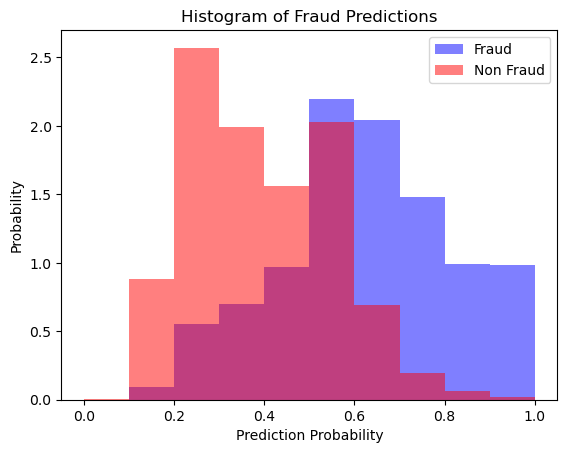

In [164]:
import matplotlib.pyplot as plt

plt.hist(fraud_cases, bins=10, range=(0, 1), color="blue", density=True, alpha=0.5,label="Fraud")
plt.hist(non_fraud_cases, bins=10, range=(0, 1), color="red", density=True, alpha=0.5, label="Non Fraud")
plt.xlabel('Prediction Probability')
plt.ylabel('Probability')
plt.title('Histogram of Fraud Predictions')
plt.legend()
plt.show()


In [19]:
temp = X_val.copy()
temp['predicted'] = y_pred
temp['true'] = y_val

In [60]:
fraud_cases = temp[temp['true'] == 1]
non_fraud_cases = temp[temp['true']==0]

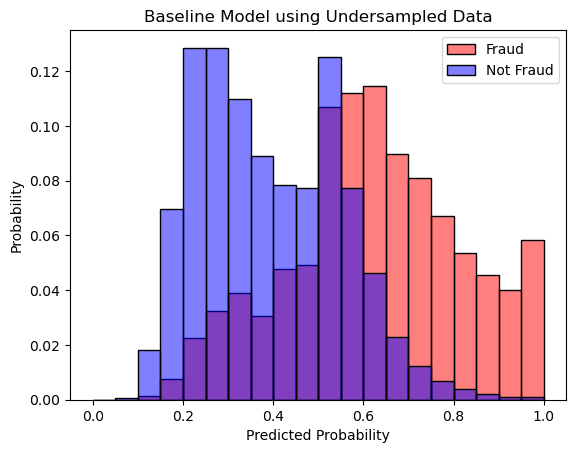

In [61]:
fig, ax = plt.subplots()
sns.histplot(data=fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='red', alpha=0.5, label='Fraud')
sns.histplot(data=non_fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='blue', alpha=0.5, label='Not Fraud')
plt.title("Baseline Model using Undersampled Data")
plt.xlabel("Predicted Probability")
ax.legend()
plt.show()

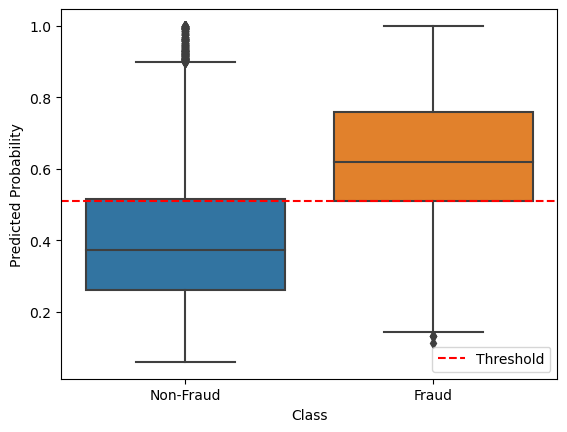

In [40]:
threshold=0.51
sns.boxplot(data=temp, x='true', y='predicted')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.xlabel("Class")
plt.ylabel("Predicted Probability")
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

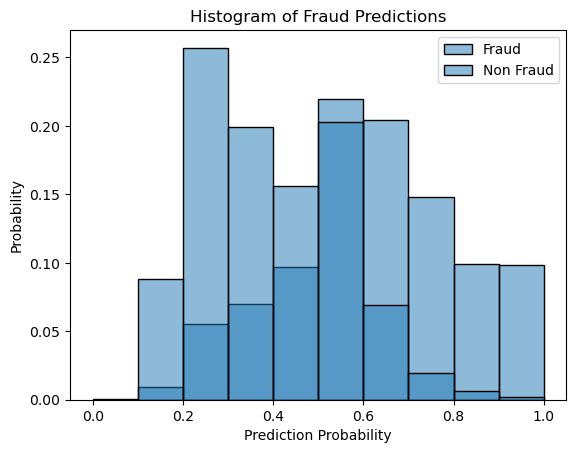

In [163]:
import seaborn as sns

sns.histplot(fraud_cases, binrange=(0, 1), stat="probability", bins=10, color="blue", label="Fraud")
sns.histplot(non_fraud_cases, binrange=(0, 1), stat="probability", bins=10, color="red", label="Non Fraud")
plt.xlabel('Prediction Probability')
plt.ylabel('Probability')
plt.title('Histogram of Fraud Predictions')
plt.legend()
plt.show()


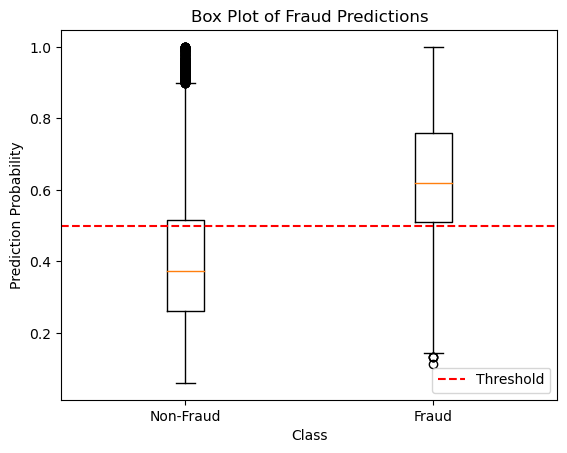

In [154]:
threshold = 0.5
plt.boxplot([non_fraud_cases.flatten(), fraud_cases.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot of Fraud Predictions')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

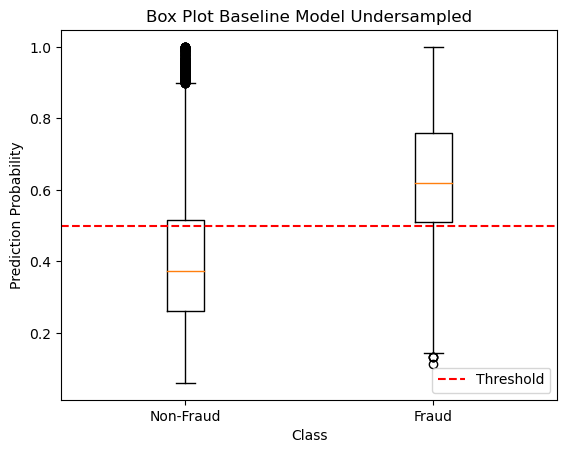

In [172]:
threshold = 0.5
plt.boxplot([non_fraud_cases.flatten(), fraud_cases.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot Baseline Model Undersampled')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

# Model 2

In [54]:
model2 = keras.models.load_model('model_v2/model_v2_epoch_05_recall0.97_auc0.83_checkpoint.h5')

In [55]:
# tensorflow model prediction
y_pred2 = model2.predict(X_val)

3691/3691 [==============================] - 6s 2ms/step


In [56]:
y_pred2_binary = np.round(y_pred2).flatten()

In [57]:
cm2 = confusion_matrix(y_val, y_pred2_binary)

In [58]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm2.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

[Text(0, 0.5, 'Non Fraud'), Text(0, 1.5, 'Fraud')]

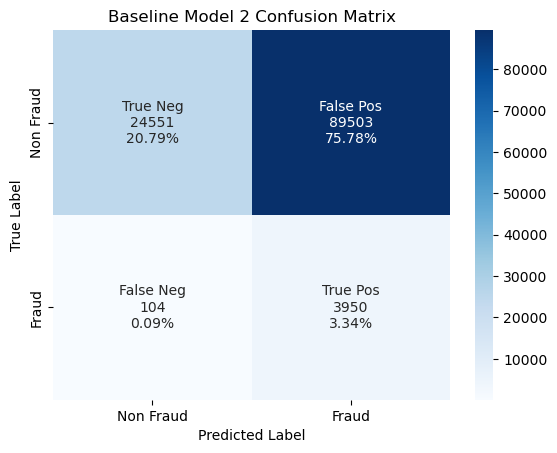

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
sns.heatmap(cm2, annot=labels, fmt='', cmap='Blues')
plt.title("Baseline Model 2 Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
ax.xaxis.set_ticklabels(['Non Fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Non Fraud', 'Fraud'])

In [50]:
tn, fp, fn, tp = cm2.ravel()
fpr = fp / (fp + tn)

In [51]:
fpr

0.7847423150437512

In [52]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1 = (2 * recall * precision) / (recall + precision)
y_pred2_keras = y_pred2.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred2_keras)
auc_keras = auc(fpr_keras, tpr_keras)

print(f"FPR: {fpr}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")
print(f"AUC: {auc_keras}")

FPR: 0.7847423150437512
Recall: 0.9743463246176616
Precision: 0.042267235936781056
Accuracy: 0.24131303552680597
F1: 0.08101982421774846
AUC: 0.833797518332504


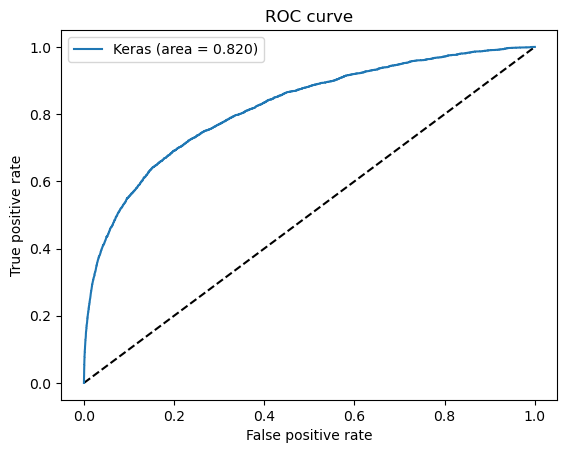

In [118]:
from sklearn.metrics import roc_curve

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [168]:
fraud_cases2 = y_pred2[y_val == 1]
non_fraud_cases2 = y_pred2[y_val == 0]

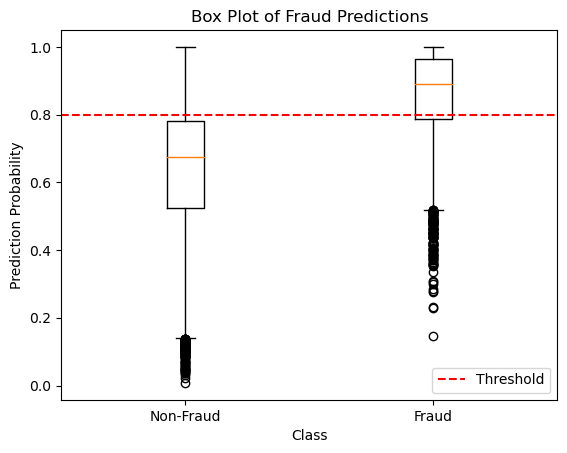

In [170]:
threshold = 0.8
plt.boxplot([non_fraud_cases2.flatten(), fraud_cases2.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot of Fraud Predictions')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()